# Detecting fires using Sentinel-2

In this trial notebook the Sentinel-2 data sets are explored using a popular remote sensing composites: the false color IR RGB stack and the NBR index. Computations are applied to the coast of Australia, hit by fires during December 2019.<br> 
Raster data sets are read and stacked together along the _band_ dimension, then images are visualised. The NBR computation helps in a better detection vegetation changes all over the tile. <br>
👇👇👇<br>
**Requirements:**
- `matplotlib 3.1.3`
- `numpy 1.18.1`
- `pandas 1.0.1` 
- `rasterio 1.1.1`
- `xarray 0.15.0`

In [1]:
import os, sys
sys.path.append(os.path.join(os.path.expanduser("~"),"Trials/modules"))
import qm
import data_processing_S2_affine as dp

You can choose to work with local files or using the Advanced API. Functions in this tutorial can manage both choices independently and automatically, but only if product of interest are provided as an input list. <br>
### Using the Advanced API (ENS)
In this case your list must contain the position of products in the remote file system. Note that this list is automatically provided using the `SEARCH.ipynb` trial notebook, aimed at facilitating the data access via ENS. Products are found via ENS at their pseudopath, accessed and processed in situ, without any local download. <br>
### Using OData API
Alternatively you can load a custom list containing the products downloaded in the `local_files` folder. To do that, you can use the `download` function provided in the `qm` module, which will download and save items via your own Jupyter Notebook using OData protocol. Follow the example provided below or check out `DISCOVER_ONDA.ipynb`. <br>
👇 To download a product of interest run the cell below and find out the item in the 📁`local_files` folder placed in your root workspace. The 📄`list_local.txt` file will be created and updated in this working directory with the new downloaded item authomatically.

In [4]:
faus = dp.product("tiles_T56HKF.txt") # load your custom product list

## Sentinel-2 bands at your disposal

|MSI band|Descriptor|Central wavelength|Resolution|
|--------|----------|------------------|----------|
|Band 2|B|490 nm|10m|
|Band 3|G|560 nm|10m|
|Band 4|R|665 nm|10m|
|Band 8|NIR|833 nm|10m|
|Band 5|RedEdge 1|705|20m|
|Band 6|RedEdge 2|740|20m|
|Band 7|RedEdge 3|783|20m|
|Band 8A|Narrow NIR|865|20m|
|Band 9| Water Vapor|945|60m|
|Band 10|SWIR Cirrus|1373|60m|
|Band 11|SWIR 1|1610|20m|
|Band 12|SWIR 2|2190|20m|

⚠️ Be careful that color composition and visualisation are a memory consuming processing tasks. Check out RAM information displayed in your IDLE.

### The true color RGB stack

The combination (R,G,B) = (B04,B03,B02) is the popular true color RGB stack. You can apply this composition to your own dataset using the `rgb_bands` function provided in the `data_processing_S2_affine` module.

### A false color IR RGB stack

The combination (R,G,B) = (B12,B11,B05) provides a natural like rendition while also penetrating atmospheric particles, smoke and haze. Hot surfaces such as forest fires saturate the Mid IR bands and thus appear in shades of red or yellow. You can apply this composition to your own dataset using the `falseir_rgb_bands` function provided in the `data_processing_S2_affine` module.

### Affine reprojection of geo-coordinates

Sentinel-2 `.jp2` data are already geo-referenced but projection is not suitable for a (_lat_,_lon_) clip as it is. The `reproject` function provides the reprojection over bands specified as input argument. You can also call the `clip` function providing the input reprojected dataset and (_xmin_,_xmax_,_ymin_,_ymax_) boundaries to obtain a subset of the image (this will speed-up computations).

In [5]:
re_frgb = []
for file in faus:
    re_frgb.append(dp.reproject(bands=dp.falseir_rgb_bands(file)))

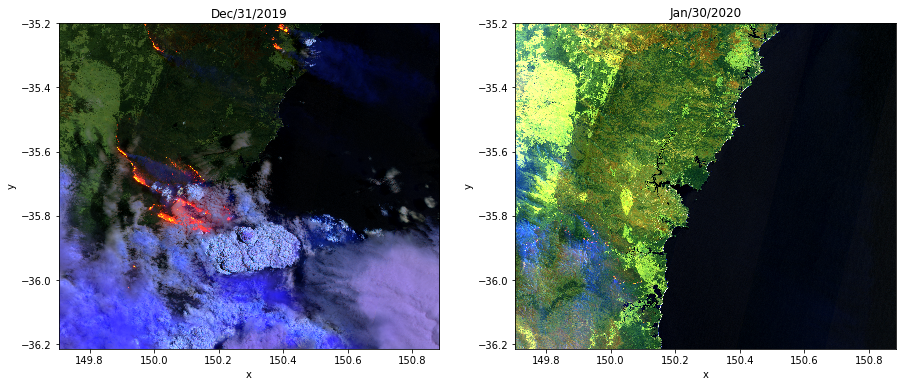

In [7]:
import matplotlib.pyplot as plt

titles = dp.dates(faus) # product date 
fig,ax = plt.subplots(1,2,figsize=(15,6))
re_frgb[0].plot.imshow(robust=True,ax=ax[0]);
re_frgb[1].plot.imshow(robust=True,ax=ax[1]);
for i,axs in enumerate(ax.flat):
    axs.set(title=titles[i])

## NBR to detect burnt areas

To detect burned areas, the _Normalized Burnt Ratio_ (NBR) index is the most appropriate choice, highlighting burnt areas in large fire zones. Here we use reflectances at B8A and B12 combined in the following ratio:

\begin{equation}
\text{NBR}=\frac{R_{B8A}-R_{B12}}{R_{B8A}+R_{B12}}
\end{equation}

You can use the function `bands` to search for all bands given the input resolution, of 20 meters in this case; we selected indexes 8 and 9 corresponding to the bands needed for the computation. The function `ratio` will compute the normalised difference given the input _DataArray_. Pay attention to the sort order in which bands are passed to functions.

In [ ]:
# print out all bands on screen and pick up idexes you need for the following computation
nbr_bands = dp.bands(faus[0],res='20m')
print('\n\n'.join(nbr_bands))

In [8]:
nbr = []
for file in faus:
    nbr_bands = dp.bands(file,res='20m')
    re_nbr = dp.reproject(bands=sorted(nbr_bands[8:10],reverse=True)) # 8,9 indexes for NBR
    nbr.append(dp.ratio(re_nbr))

📌 To observe burn severity, you can also subtract the post-fire NBR image from the pre-fire NBR image. <br>
Values in the image below show lighter pixels indicating burned areas.

In [10]:
import hvplot.xarray

im_nbr = []
dates = dp.dates(faus)
for i,val in enumerate(nbr):
    im_nbr.append(val.hvplot.quadmesh(x='x',y='y',cmap='binary',rasterize=True,dynamic=True, aspect='equal',
                                      clabel='NBR',title=titles[i]))

(im_nbr[0]+im_nbr[1]).cols(2)

:Layout
   .DynamicMap.I  :DynamicMap   []
      :Image   [x,y]   (value)
   .DynamicMap.II :DynamicMap   []
      :Image   [x,y]   (value)